In [2]:
import os
import json
from collections import OrderedDict
from operator import itemgetter

from tqdm import tqdm
import numpy as np
import pandas as pd

from keras.layers import Embedding, Dense, Input, Dropout, BatchNormalization, Flatten
from keras.layers.merge import concatenate, add
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2


import matplotlib.pyplot as plt

Using TensorFlow backend.


In [7]:
np.random.seed(42)
NUM_RATINGS = 50000000000000000000000
GENRES = set()
num_factors = 50
dir_name = 'run_{}'.format(NUM_RATINGS)
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [10]:
users_df = pd.read_csv('datasets/users_cleaned.csv').dropna(subset=['user_id', 'username'])
users_df.columns

Index(['username', 'user_id', 'user_watching', 'user_completed', 'user_onhold',
       'user_dropped', 'user_plantowatch', 'user_days_spent_watching',
       'gender', 'location', 'birth_date', 'access_rank', 'join_date',
       'last_online', 'stats_mean_score', 'stats_rewatched', 'stats_episodes'],
      dtype='object')

In [11]:
anime_df = pd.read_csv('datasets/anime_cleaned.csv').dropna(subset=['anime_id', 'title'])
anime_df.columns

Index(['anime_id', 'title', 'title_english', 'title_japanese',
       'title_synonyms', 'image_url', 'type', 'source', 'episodes', 'status',
       'airing', 'aired_string', 'aired', 'duration', 'rating', 'score',
       'scored_by', 'rank', 'popularity', 'members', 'favorites', 'background',
       'premiered', 'broadcast', 'related', 'producer', 'licensor', 'studio',
       'genre', 'opening_theme', 'ending_theme', 'duration_min',
       'aired_from_year'],
      dtype='object')

In [5]:
anime_info_cols = [
    'anime_id', 'episodes', 'aired_from_year', 'rating', 'type', 'title'
]
anime_info_df = anime_df[anime_info_cols]

In [6]:
# genres = set()
# genres_split = anime_info_df.dropna(subset=['genre']).genre.str.split(', ')
# for ix, genre_list in genres_split.iteritems():
#     if isinstance(genre_list, list):
#         for genre in genre_list:
#             genres.add(genre)
# for genre in tqdm(genres):
#     anime_info_df.loc[:, 'genre_{}'.format(genre)] = anime_info_df.apply(
#         lambda _: -1 if pd.isnull(_.genre) else int(genre in _.genre), axis=1
#     )
# anime_info_df.drop('genre', axis=1)

In [6]:
categorical_vars = ['rating', 'type']
for cat in categorical_vars:
    print("Category {}: {}".format(cat, anime_info_df[cat].nunique()))
    anime_info_df = pd.concat(
        [anime_info_df, pd.get_dummies(anime_info_df[cat], prefix=cat)], axis=1
    ).drop(cat, axis=1)

Category rating: 7
Category type: 6


In [7]:
cat_feat_names = list(anime_info_df.columns)
cat_feat_names.remove('anime_id')

In [31]:
ratings_df = pd.read_csv('myanimelist/animelists_cleaned.csv', nrows=NUM_RATINGS).dropna(subset=['username', 'anime_id'])
ratings_df.columns

Index(['username', 'anime_id', 'my_watched_episodes', 'my_start_date',
       'my_finish_date', 'my_score', 'my_status', 'my_rewatching',
       'my_rewatching_ep', 'my_last_updated', 'my_tags'],
      dtype='object')

In [32]:
anime_titles = anime_df.set_index('anime_id')['title'].to_dict()

In [33]:
usernames2userid = users_df.set_index('username')['user_id'].to_dict()

In [34]:
ratings_df.loc[:, 'user_id'] = ratings_df.username.apply(lambda x: usernames2userid[x])
ratings_df = ratings_df[['user_id', 'anime_id', 'my_score']]
ratings_df.head()

,user_id,anime_id,my_score
0,2255153,21,9
1,2255153,59,7
2,2255153,74,7
3,2255153,120,7
4,2255153,178,7


In [13]:
# num_users = ratings_df.user_id.nunique()
# num_anime = ratings_df.anime_id.nunique()
# num_users, num_anime
num_users, num_anime = (108709, 6668)

In [36]:
users = ratings_df.user_id.unique()
anime = ratings_df.anime_id.unique()

In [37]:
user2idx = {int(o): int(i) for i, o in enumerate(users)}
anime2idx = {int(o): int(i) for i, o in enumerate(anime)}

In [38]:
idx2anime = {int(v): int(k) for k, v in anime2idx.items()}
idx2user = {int(v): int(k) for k, v in user2idx.items()}

In [39]:
ratings_df = pd.merge(ratings_df, anime_info_df, on='anime_id', how='left')

In [40]:
ratings_df.anime_id = ratings_df.anime_id.apply(lambda x: anime2idx[x])
ratings_df.user_id = ratings_df.user_id.apply(lambda x: user2idx[x])

In [83]:
# import json
# mappings = {
#     'idx2anime': idx2anime,
#     'idx2user': idx2user,
#     'user2idx': user2idx,
#     'anime2idx': anime2idx
# }

# with open('anime_user_rating_mapping.json', 'w') as fp:
#     json.dump(mappings, fp)

In [42]:
ratings_df.head()

,user_id,anime_id,my_score,episodes,aired_from_year,title,rating_G - All Ages,rating_None,rating_PG - Children,rating_PG-13 - Teens 13 or older,rating_R - 17+ (violence & profanity),rating_R+ - Mild Nudity,rating_Rx - Hentai,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,0,0,9,0,1999.0,One Piece,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,1,7,26,2002.0,Chobits,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,2,7,26,2004.0,Gakuen Alice,1,0,0,0,0,0,0,0,0,0,0,0,1
3,0,3,7,26,2001.0,Fruits Basket,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,4,7,26,2003.0,Ultra Maniac,1,0,0,0,0,0,0,0,0,0,0,0,1


In [92]:
# bins = range(-1, len(ratings_df) + 5000000, 5000000)
# ratings_df['binned'] = pd.cut(ratings_df.index, bins)

In [93]:
# for file_id, (index, group) in tqdm(enumerate(ratings_df[['user_id', 'anime_id', 'my_score', 'binned']].groupby('binned'))):
#     group[['user_id', 'anime_id', 'my_score']].to_csv('processed_ratings/user_ratings_processed_{}.csv'.format(file_id), index=False)



0it [00:00, ?it/s]

1it [00:14, 14.10s/it]

2it [00:27, 13.96s/it]

3it [00:41, 13.95s/it]

4it [00:55, 14.00s/it]

5it [01:09, 14.07s/it]

6it [01:24, 14.06s/it]

7it [01:27, 10.94s/it]

In [91]:
# len(ratings_df) / 5000000

6.2567574

In [20]:
msk = np.random.rand(len(ratings_df)) < 0.8
trn = ratings_df[msk]
val = ratings_df[~msk]

In [4]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [5]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [14]:
user_in, u = embedding_input('user_in', num_users, num_factors, 1e-4)
anime_in, m = embedding_input('anime_in', num_anime, num_factors, 1e-4)
# cat_in = Input(shape=(len(cat_feat_names),), name='cat_features')

In [23]:
# ub = create_bias(user_in, num_users)
# mb = create_bias(anime_in, num_anime)
# x = concatenate([u, m])
# x = Flatten()(x)
# x = add([x, ub])
# x = add([x, mb])
# x = Dropout(0.3)(x)
# x = Dense(124, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.45)(x)
# x = Dense(70, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.75)(x)
# x = Dense(1)(x)
# nn = Model([user_in, anime_in], x)

In [15]:
x = concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(124, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(70, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, anime_in], x)


# x = concatenate([u, m])
# x = Flatten()(x)
# x = Dropout(0.3)(x)
# x = concatenate([x, cat_in])
# x = Dense(124, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.45)(x)
# x = Dense(70, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.75)(x)
# x = Dense(1)(x)
# nn = Model([user_in, anime_in, cat_in], x)

In [25]:
# nn.compile(Adam(0.001), loss='mse')
# nn.fit([trn.user_id, trn.anime_id], trn.my_score, batch_size=2048, epochs=12,
#        validation_data=([val.user_id, val.anime_id], val.my_score))

Train on 25030823 samples, validate on 6252964 samples
Epoch 1/12
25030823/25030823 [==============================] - 1079s 43us/step - loss: 12.3412 - val_loss: 10.9606
Epoch 2/12
25030823/25030823 [==============================] - 1028s 41us/step - loss: 11.2579 - val_loss: 10.7712
Epoch 3/12
25030823/25030823 [==============================] - 1032s 41us/step - loss: 11.1945 - val_loss: 10.6933
Epoch 4/12
25030823/25030823 [==============================] - 1033s 41us/step - loss: 11.1917 - val_loss: 10.6860
Epoch 5/12
25030823/25030823 [==============================] - 1032s 41us/step - loss: 11.1910 - val_loss: 10.6632
Epoch 6/12
25030823/25030823 [==============================] - 1032s 41us/step - loss: 11.1885 - val_loss: 10.6654
Epoch 7/12
25030823/25030823 [==============================] - 1031s 41us/step - loss: 11.1747 - val_loss: 10.6312
Epoch 8/12
25030823/25030823 [==============================] - 1029s 41us/step - loss: 11.1709 - val_loss: 10.6464
Epoch 9/12
250308

In [26]:
# nn.compile(Adam(0.0001), loss='mse')
# nn.fit([trn.user_id, trn.anime_id], trn.my_score, batch_size=2048, epochs=14,
#        validation_data=([val.user_id, val.anime_id], val.my_score))

Train on 25030823 samples, validate on 6252964 samples
Epoch 1/14
25030823/25030823 [==============================] - 1035s 41us/step - loss: 10.5042 - val_loss: 9.7665
Epoch 2/14
25030823/25030823 [==============================] - 982s 39us/step - loss: 10.1442 - val_loss: 9.5747
Epoch 3/14
25030823/25030823 [==============================] - 941s 38us/step - loss: 10.0053 - val_loss: 9.4825
Epoch 4/14
25030823/25030823 [==============================] - 1028s 41us/step - loss: 9.9312 - val_loss: 9.4273
Epoch 5/14
25030823/25030823 [==============================] - 949s 38us/step - loss: 9.8820 - val_loss: 9.3979
Epoch 6/14
25030823/25030823 [==============================] - 949s 38us/step - loss: 9.8468 - val_loss: 9.3665
Epoch 7/14
25030823/25030823 [==============================] - 950s 38us/step - loss: 9.8236 - val_loss: 9.3464
Epoch 8/14
25030823/25030823 [==============================] - 950s 38us/step - loss: 9.8047 - val_loss: 9.3374
Epoch 9/14
25030823/25030823 [======

In [27]:
# nn.save_weights('{}/{}_cat_feat_ratings.h5'.format(dir_name, NUM_RATINGS))

In [18]:
nn.load_weights('{}_feat_ratings.h5'.format(NUM_RATINGS))

In [23]:
import pickle
pickle.dump(nn.get_weights()[1], open('anime_embeddings.pkl', 'wb'))

In [28]:
# nn.compile(Adam(0.0001), loss='mse')
# nn.fit([trn.user_id, trn.anime_id], trn.my_score, batch_size=2048, epochs=6,
#        validation_data=([val.user_id, val.anime_id], val.my_score))

In [29]:
# nn.compile(Adam(0.0001), loss='mse')
# nn.fit([trn.user_id, trn.anime_id], trn.my_score, batch_size=2048, epochs=15,
#        validation_data=([val.user_id, val.anime_id], val.my_score))

In [30]:
# nn.compile(Adam(0.0001), loss='mse')
# nn.fit([trn.user_id, trn.anime_id], trn.my_score, batch_size=5000, epochs=20,
#        validation_data=([val.user_id, val.anime_id], val.my_score))

In [31]:
# nn.save_weights('{}_feat_ratings_2.h5'.format(NUM_RATINGS))

In [26]:
condensed_latent_features = 5

In [27]:
from sklearn.decomposition import PCA
weights = nn.get_weights()[1]
pca = PCA(n_components=condensed_latent_features)
anime_emb_enc = pca.fit(weights.T).components_
anime_emb_enc.shape

(5, 6668)

In [28]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
anime_emb_enc_tsne = tsne.fit(weights).embedding_

In [29]:
anime_emb_enc_tsne.shape

(6668, 2)

In [30]:
anime_emb_enc_tsne[[2, 3, 4]].T[0]

array([39.264473, 37.052067, 44.003017], dtype=float32)

In [38]:
g = ratings_df.groupby('anime_id')['my_score'].mean()
top_anime = g.sort_values(ascending=False)
top_anime = np.array(top_anime.index)

feat_dir_name = '{}/condensed_latent_features_{}'.format(dir_name, condensed_latent_features)
if not os.path.exists(feat_dir_name):
    os.makedirs(feat_dir_name)

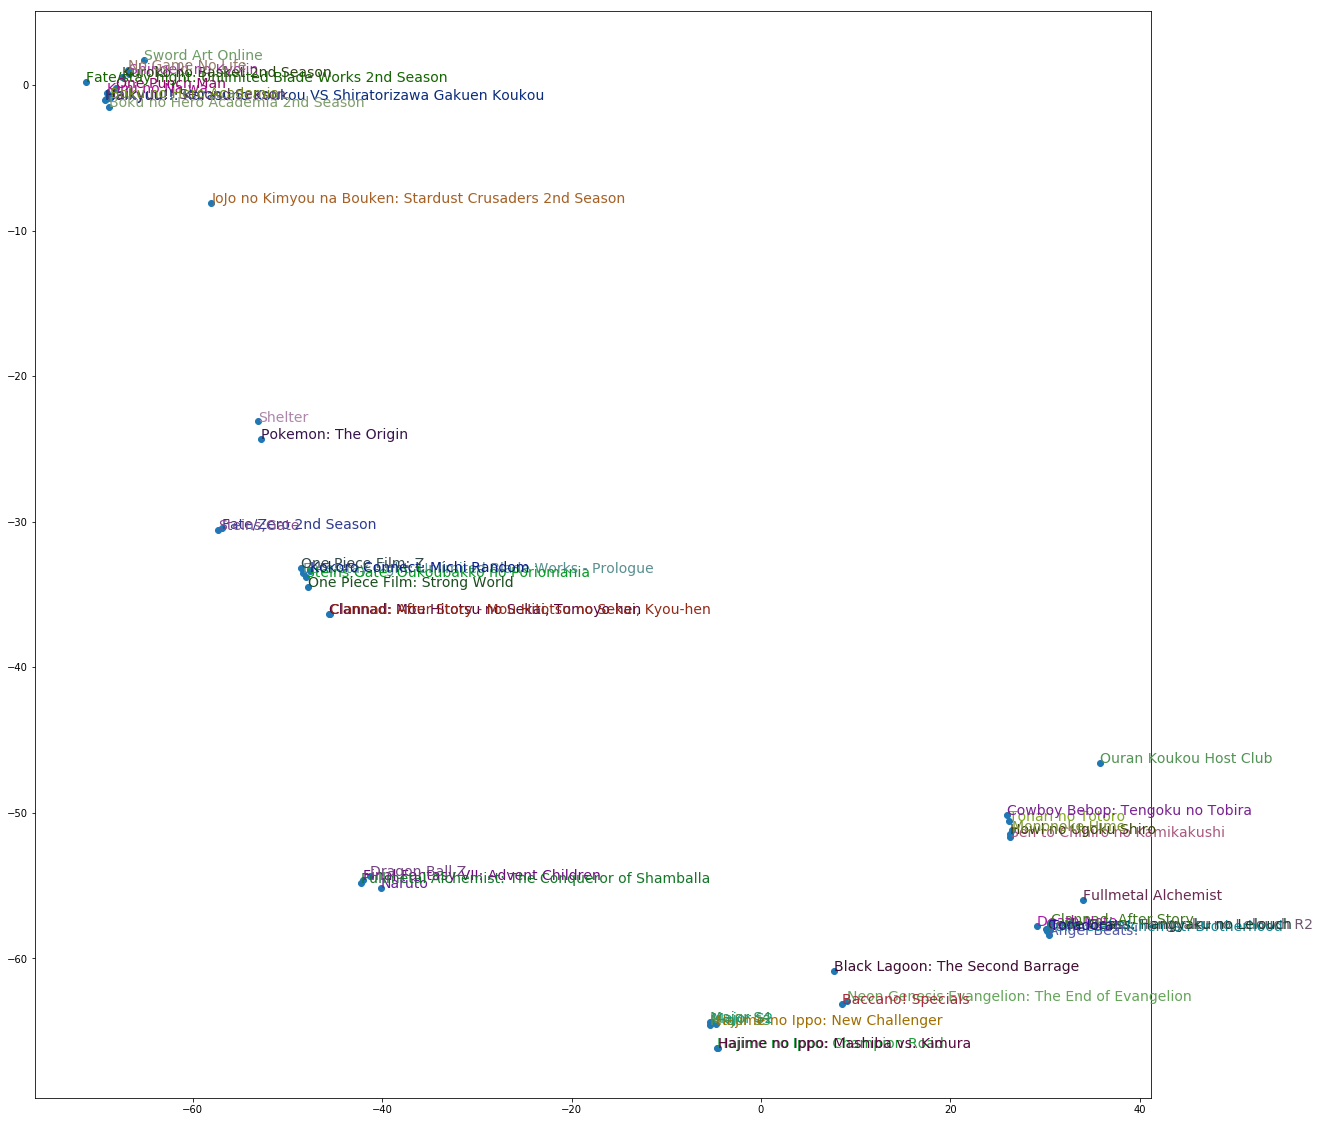

In [40]:
def generate_plot_for_top_n_anime(embeddings, topn=None, top_anime=top_anime, figsize=(20, 20), plot=True):
    anime_plots = []
    topn = len(top_anime) if topn is None else topn
    plt.figure(figsize=figsize)
    plt.scatter(anime_emb_enc_tsne[top_anime[:topn]].T[0], anime_emb_enc_tsne[top_anime[:topn]].T[1])
    for idx in top_anime[:topn]:
        anime_plots.append([anime_titles[idx2anime[idx]], embeddings[idx]])
        if plot:
            plt.text(embeddings[idx][0],
                     embeddings[idx][1],
                     anime_titles[idx2anime[idx]], color=np.random.rand(3)*0.7, fontsize=14)
    if plot:
        plt.show()
    return anime_plots
    
anime_topn_tsne = generate_plot_for_top_n_anime(embeddings=anime_emb_enc_tsne, topn=50, plot=True)

In [41]:
[(anime_titles[idx2anime[x]], anime_emb_enc_tsne[x]) for x in top_anime[:10]]

[('Death Note', array([ 29.107496, -57.794315], dtype=float32)),
 ('Sen to Chihiro no Kamikakushi',
  array([ 26.314522, -51.629276], dtype=float32)),
 ('Code Geass: Hangyaku no Lelouch R2',
  array([ 30.075172, -58.00462 ], dtype=float32)),
 ('Shingeki no Kyojin', array([-66.72756  ,   0.7685507], dtype=float32)),
 ('One Punch Man', array([-68.08607   ,  -0.22375347], dtype=float32)),
 ('Howl no Ugoku Shiro', array([ 26.310244, -51.4448  ], dtype=float32)),
 ('Kimi no Na wa.', array([-69.063515 ,  -0.5619676], dtype=float32)),
 ('Fullmetal Alchemist: Brotherhood',
  array([ 30.196434, -58.103226], dtype=float32)),
 ('Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou',
  array([-69.24963  ,  -1.0397582], dtype=float32)),
 ('Code Geass: Hangyaku no Lelouch',
  array([ 30.34155, -57.96043], dtype=float32))]

In [42]:
all_anime_sorted_by_feat = {}
for i in range(condensed_latent_features):
    feature = anime_emb_enc[i]
    anime_comp = [{'score': float(f), 'title': anime_titles[anime[i]]} for f,i in zip(feature, top_anime)]
    anime_sorted_by_feature = sorted(anime_comp, key=lambda x: x['score'], reverse=True)
    all_anime_sorted_by_feat[i] = pd.merge(
        anime_df[anime_info_cols + ['genre']],
        pd.DataFrame(anime_sorted_by_feature),
        how='inner',
        on='title'
    ).sort_values(by='score').fillna('-').to_dict(orient='records')
    with open('{}/{}_condensed_latent_feature_{}.json'.format(feat_dir_name, NUM_RATINGS, i), 'w') as fp:
        json.dump(all_anime_sorted_by_feat[i], fp)

In [43]:
def display_sorted_anime_top_bottom_n(idx, topn=5):
    records = []
    print("Latent Feature {}".format(idx))
    records.extend([{'title': r['title'], 'score': r['score']} for r in all_anime_sorted_by_feat[idx][:5]])
    records.extend([{'title': r['title'], 'score': r['score']} for r in all_anime_sorted_by_feat[idx][-5:]])
    return pd.DataFrame(records).sort_values(by='score', ascending=False)

In [33]:
display_sorted_anime_top_bottom_n(0)

Latent Feature 0


,score,title
9,0.042226,Gakuen Tokusou Hikaruon
8,0.042124,Urusei Yatsura: The Shougaibutsu Suieitaikai
7,0.041689,Kindaichi Shounen no Jikenbo Specials
6,0.041456,Cobra The Animation
5,0.041279,Juubee-chan 2: Siberia Yagyuu no Gyakushuu
4,-0.056661,Noragami Aragoto
3,-0.058290,Suisei no Gargantia
2,-0.058439,Ore no Imouto ga Konnani Kawaii Wake ga Nai Sp...
1,-0.062340,Hajime no Ippo: Boxer no Kobushi
0,-0.062741,Naruto: Shippuuden


In [34]:
display_sorted_anime_top_bottom_n(1)

Latent Feature 1


,score,title
9,0.028663,Full Metal Panic? Fumoffu
8,0.028603,Amagi Brilliant Park: Nonbirishiteiru Hima ga ...
7,0.028308,Final Fantasy VII: Advent Children
6,0.028305,Sora no Otoshimono: Tokeijikake no Angeloid
5,0.028137,Detective Conan Movie 06: The Phantom of Baker...
4,-0.034712,Gochuumon wa Usagi desu ka??
3,-0.034928,Nisemonogatari
2,-0.037041,Metropolis
1,-0.037202,Gatchaman Crowds Insight
0,-0.040775,Cowboy Bebop


In [35]:
display_sorted_anime_top_bottom_n(2)

Latent Feature 2


,score,title
9,0.044868,JoJo no Kimyou na Bouken: Stardust Crusaders
8,0.042611,Rosario to Vampire Capu2
7,0.040249,Crayon Shin-chan
6,0.040227,Yowamushi Pedal: Special Ride
5,0.039725,Highschool of the Dead
4,-0.030886,Amaenaide yo!!
3,-0.031227,Isekai no Seikishi Monogatari
2,-0.032082,Gravitation
1,-0.032119,Mobile Suit Gundam SEED Destiny Final Plus: Th...
0,-0.032792,Slayers Revolution


In [36]:
display_sorted_anime_top_bottom_n(3)

Latent Feature 3


,score,title
9,0.050494,Pokemon Best Wishes! Season 2: Kyurem vs. Seik...
8,0.049575,Kara no Kyoukai 1: Fukan Fuukei
7,0.049379,Dragon Ball Kai (2014)
6,0.048040,Yuu☆Yuu☆Hakusho: Eizou Hakusho II
5,0.047803,Gintama.
4,-0.040050,Detective Conan Movie 13: The Raven Chaser
3,-0.040069,"Natsu-iro Egao de 1, 2, Jump!"
2,-0.042178,Code Geass: Hangyaku no Lelouch
1,-0.042972,One Piece: Episode of Nami - Koukaishi no Nami...
0,-0.045050,Fullmetal Alchemist


In [37]:
display_sorted_anime_top_bottom_n(4)

Latent Feature 4


,score,title
9,0.048872,Love Stage!!
8,0.044441,Slayers Evolution-R
7,0.043818,Isshuukan Friends. Specials
6,0.042250,Tantei Opera Milky Holmes Dai 2 Maku
5,0.041469,Kishin Houkou Demonbane (TV)
4,-0.045650,"Dakara Boku wa, H ga Dekinai. OVA"
3,-0.045821,Initial D Second Stage
2,-0.048783,Tengen Toppa Gurren Lagann
1,-0.048936,Nisemonogatari
0,-0.051471,Inazuma Eleven


In [52]:
anime_emb_enc_tsne.shape

(50, 2)

In [ ]:
def generate_plot_for_top_n_anime(x_emb, y_emb, topn=None, top_anime=top_anime, figsize=(20, 20), plot=True):
    anime_plots = []
    topn = len(top_anime) if topn is None else topn
    X = x_emb[:topn]
    Y = y_emb[:topn]
    if plot:
        plt.figure(figsize=figsize)
        plt.scatter(X, Y)
    
    for i, x, y in zip(top_anime[:topn], X, Y):
        anime_plots.append([anime_titles[anime[i]], x, y])
        if plot:
            plt.text(x,y, anime_titles[anime[i]], color=np.random.rand(3)*0.7, fontsize=14)
    if plot:
        plt.show()
    return anime_plots
    
anime_topn = generate_plot_for_top_n_anime(x_emb=anime_emb_enc[0], y_emb=anime_emb_enc[1], topn=50, plot=True)

In [139]:
# from itertools import combinations
# from scipy.spatial import distance

# for feat1_idx, feat2_idx in tqdm(list(combinations(range(condensed_latent_features), 2))):
#     feat1 = anime_emb_enc[feat1_idx]
#     feat2 = anime_emb_enc[feat2_idx]
#     anime_all = generate_plot_for_top_n_anime(
#         x_emb=feat1, y_emb=feat2, topn=None, plot=False
#     )
#     pairwise_anime_distance = []
#     for anime1 in anime_all:
#         for anime2 in anime_topn:
#             if anime1[0] != anime2[0]:
#                 pairwise_anime_distance.append([
#                         anime1[0], anime2[0], distance.euclidean(
#                             (anime1[1], anime1[2]), (anime2[1], anime2[2])
#                         )
#                 ])
#     with open('{}/{}_pairwise_dist-{}-{}.json'.format(feat_dir_name, NUM_RATINGS, feat1_idx, feat2_idx), 'w') as fp:
#         json.dump(pairwise_anime_distance, fp)

100%|██████████| 10/10 [01:09<00:00,  6.94s/it]


In [44]:
from scipy.spatial import distance
anime_mapping_distances = []
threshold = 0.01
topn=10
seen = set()
for anime1_idx in tqdm(top_anime):
    count = 0
    l = []
    for anime2_idx in top_anime:
        if (anime2_idx not in seen) and (anime1_idx != anime2_idx):
            seen.add(anime1_idx)
            anime1 = anime_titles[anime[anime1_idx]]
            anime2 = anime_titles[anime[anime2_idx]]
            anime1_features = [anime_emb_enc[i][anime1_idx] for i in range(condensed_latent_features)]
            anime2_features = [anime_emb_enc[i][anime2_idx] for i in range(condensed_latent_features)]
            euc_distance = distance.euclidean(
                anime1_features, anime2_features
            )
            if euc_distance < threshold:
                l.append([anime1, anime2, euc_distance])
    anime_mapping_distances.extend(sorted(l, key=lambda x: x[2])[:topn])
with open('{}/{}_combined_dist_threshold-{}_topn-{}.json'.format(feat_dir_name, NUM_RATINGS, threshold, topn), 'w') as fp:
    json.dump(anime_mapping_distances, fp)

  1%|          | 53/6668 [00:08<17:00,  6.48it/s]


KeyboardInterrupt: 

In [53]:
len(anime_mapping_distances)

6978982

100%|██████████| 49/49 [00:31<00:00,  1.01it/s]


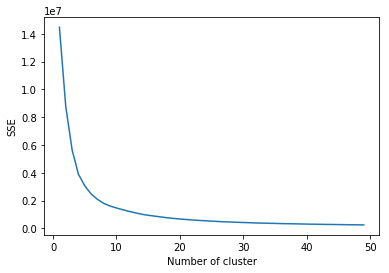

In [74]:
# from sklearn.datasets import load_iris
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# sse = {}
# for k in tqdm(range(1, 50)):
#     kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_tsne)
# #     clusters["clusters"] = kmeans.labels_
#     #print(data["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure()
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel("Number of cluster")
# plt.ylabel("SSE")
# plt.show()


100%|██████████| 99/99 [02:47<00:00,  2.90s/it]

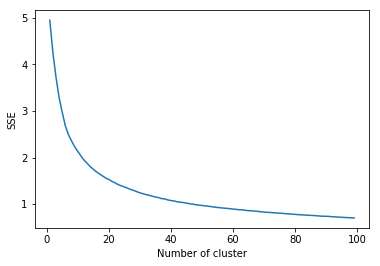

In [58]:
# from sklearn.datasets import load_iris
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# sse = {}
# for k in tqdm(range(1, 100)):
#     kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
# #     clusters["clusters"] = kmeans.labels_
#     #print(data["clusters"])
#     sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
# plt.figure()
# plt.plot(list(sse.keys()), list(sse.values()))
# plt.xlabel("Number of cluster")
# plt.ylabel("SSE")
# plt.show()

In [45]:
data_tsne = []
for anime1_idx in tqdm(top_anime):
    data_tsne.append(anime_emb_enc_tsne[anime1_idx])

100%|██████████| 6668/6668 [00:00<00:00, 641694.64it/s]


In [48]:
from sklearn.cluster import KMeans
kmeans_tsne = KMeans(n_clusters=9, max_iter=1000).fit(data_tsne)
from collections import defaultdict
clusters_tsne = defaultdict(list)
for index, cluster_id in enumerate(kmeans_tsne.labels_):
    clusters_tsne[cluster_id].append(top_anime[index])

In [49]:
from scipy.spatial import distance
anime_cluster_distances_tsne = []
seen = set()
for cluster_id, cluster in tqdm(clusters_tsne.items()):
    for anime1_idx in cluster:
        for anime2_idx in cluster:
            if (anime2_idx not in seen) and (anime1_idx != anime2_idx):
                seen.add(anime1_idx)
                anime1 = anime_titles[idx2anime[anime1_idx]]
                anime2 = anime_titles[idx2anime[anime2_idx]]
                anime1_features = anime_emb_enc_tsne[anime1_idx]
                anime2_features = anime_emb_enc_tsne[anime2_idx]
                euc_distance = distance.euclidean(
                    anime1_features, anime2_features
                )
                anime_cluster_distances_tsne.append([anime1, anime2, euc_distance, int(cluster_id)])

with open('{}/{}_combined_cluster_tsne.json'.format(feat_dir_name, NUM_RATINGS), 'w') as fp:
    json.dump(anime_cluster_distances_tsne, fp)

100%|██████████| 9/9 [00:43<00:00,  4.21s/it]


In [146]:
from scipy.spatial import distance
anime_cluster_distances_tsne_topn = []
seen = set()
topn=100
threshold = 5
for cluster_id, cluster in tqdm(clusters_tsne.items()):
    for anime1_idx in cluster:
        for anime2_idx in cluster:
            if (anime1_idx in top_anime[:topn] or anime2_idx in top_anime[:topn]) and (anime2_idx not in seen) and (anime1_idx != anime2_idx):
                seen.add(anime1_idx)
                anime1 = anime_titles[idx2anime[anime1_idx]]
                anime2 = anime_titles[idx2anime[anime2_idx]]
                anime1_features = anime_emb_enc_tsne[anime1_idx]
                anime2_features = anime_emb_enc_tsne[anime2_idx]
                euc_distance = distance.euclidean(
                    anime1_features, anime2_features
                )
                if euc_distance < threshold:
                    anime_cluster_distances_tsne_topn.append([anime1, anime2, euc_distance, int(cluster_id)])

with open('{}/{}_combined_cluster_tsne_top-{}.json'.format(feat_dir_name, NUM_RATINGS, topn), 'w') as fp:
    json.dump(anime_cluster_distances_tsne_topn, fp)

100%|██████████| 9/9 [00:33<00:00,  3.70s/it]


In [50]:
clusters_tsne_df = pd.DataFrame(anime_cluster_distances_tsne, columns=['anime1', 'anime2', 'distance', 'cluster'])

In [51]:
cl_tsne_df = clusters_tsne_df[clusters_tsne_df['cluster'] == 8]
cl_tsne_df.sort_values(by='distance', ascending=True)[:10]

,anime1,anime2,distance,cluster
2538685,Kemonozume,Boogiepop wa Warawanai: Boogiepop Phantom,0.002250,8
2501679,Hoshi wo Ou Kodomo,Momo e no Tegami,0.037053,8
2488061,Karas,Ao no 6-gou,0.050283,8
2402859,Kaze Tachinu,Kaguya-hime no Monogatari,0.062000,8
2430903,Omoide no Marnie,Kaguya-hime no Monogatari,0.063161,8
2426119,Black Blood Brothers,Karin,0.063377,8
2529390,Cyber City Oedo 808,Project A-Ko,0.064269,8
2411429,Gedo Senki,Heisei Tanuki Gassen Ponpoko,0.071781,8
2437234,Gakuen Alice,Kiniro no Corda: Primo Passo,0.074732,8
2414946,Special A,Itazura na Kiss,0.083676,8


In [52]:
filter_name = 'Nanatsu no Taizai: Imashime no Fukkatsu'
clusters_tsne_df[
    (clusters_tsne_df['anime2'] == filter_name) | (clusters_tsne_df['anime1'] == filter_name)
].sort_values(by='distance')[:10]

,anime1,anime2,distance,cluster
2068369,Nanatsu no Taizai: Imashime no Fukkatsu,Boku no Hero Academia 3rd Season,0.063377,6
2068410,Nanatsu no Taizai: Imashime no Fukkatsu,Shokugeki no Souma: San no Sara - Toutsuki Res...,0.427323,6
2068470,Nanatsu no Taizai: Imashime no Fukkatsu,Tokyo Ghoul:re,0.645939,6
2068372,Nanatsu no Taizai: Imashime no Fukkatsu,Hinamatsuri,0.696452,6
2068462,Nanatsu no Taizai: Imashime no Fukkatsu,Golden Kamuy,1.055892,6
2062740,Megalo Box,Nanatsu no Taizai: Imashime no Fukkatsu,1.161483,6
2068439,Nanatsu no Taizai: Imashime no Fukkatsu,Wotaku ni Koi wa Muzukashii,1.358200,6
2022920,Darling in the FranXX,Nanatsu no Taizai: Imashime no Fukkatsu,1.361336,6
2068526,Nanatsu no Taizai: Imashime no Fukkatsu,Steins;Gate 0,1.374417,6
2046941,Black Clover,Nanatsu no Taizai: Imashime no Fukkatsu,1.518717,6


In [128]:
data = []
for anime1_idx in tqdm(top_anime):
    data.append([anime_emb_enc[i][anime1_idx] for i in range(condensed_latent_features)])

100%|██████████| 6668/6668 [00:00<00:00, 335290.89it/s]


In [129]:
kmeans = KMeans(n_clusters=20, max_iter=1000).fit(data)

In [130]:
from collections import defaultdict
clusters = defaultdict(list)
for index, cluster_id in enumerate(kmeans.labels_):
    clusters[cluster_id].append(top_anime[index])

In [131]:
anime_cluster_distances = []
seen = set()
for cluster_id, cluster in tqdm(clusters.items()):
    for anime1_idx in cluster:
        for anime2_idx in cluster:
            if (anime2_idx not in seen) and (anime1_idx != anime2_idx):
                seen.add(anime1_idx)
                anime1 = anime_titles[anime[anime1_idx]]
                anime2 = anime_titles[anime[anime2_idx]]
                anime1_features = [anime_emb_enc[i][anime1_idx] for i in range(condensed_latent_features)]
                anime2_features = [anime_emb_enc[i][anime2_idx] for i in range(condensed_latent_features)]
                euc_distance = distance.euclidean(
                    anime1_features, anime2_features
                )
                anime_cluster_distances.append([anime1, anime2, euc_distance, int(cluster_id)])

with open('{}/{}_combined_cluster.json'.format(feat_dir_name, NUM_RATINGS), 'w') as fp:
    json.dump(anime_cluster_distances, fp)

100%|██████████| 20/20 [00:44<00:00,  2.51s/it]


In [132]:
clusters_df = pd.DataFrame(anime_cluster_distances, columns=['anime1', 'anime2', 'distance', 'cluster'])

In [133]:
cl1_df = clusters_df[clusters_df['cluster'] == 5]
cl1_df.sort_values(by='distance', ascending=True)[:10]

,anime1,anime2,distance,cluster
314421,Dr. Slump Movie 09: Arale-chan N-cha!! Wakuwak...,Dr. Slump Movie 07: Arale-chan N-cha! Penguin ...,0.000984,5
319634,Nurse Witch Komugi-chan Magikarte Z Special,Install Pilot,0.001632,5
312555,Queen&#039;s Blade OVA Specials,Fullmetal Alchemist: The Sacred Star of Milos ...,0.001766,5
314433,Dr. Slump Movie 09: Arale-chan N-cha!! Wakuwak...,Dr. Slump Movie 05: Arale-chan Hoyoyo! Yume no...,0.002100,5
314845,Youchien Senshi: Hanamaru Girls,Dr. Slump Movie 10: Arale no Bikkuriman,0.002126,5
318315,Precure kara Minna e no Ouen Movie,Umi Monogatari: Marin no Kore Naani?,0.002174,5
280094,Hikari to Mizu no Daphne Specials,Joshikousei: Girl&#039;s High Specials,0.002278,5
316577,Ane Log: Moyako Neesan no Honpen wo Tobidashit...,K: Missing Kings - Manner Movie,0.002287,5
315324,Dr. Slump Movie 07: Arale-chan N-cha! Penguin ...,Dr. Slump Movie 05: Arale-chan Hoyoyo! Yume no...,0.002394,5
293568,Code Geass: Hangyaku no Lelouch R2 Special Edi...,Code Geass: Hangyaku no Lelouch Special Editio...,0.002571,5


In [135]:
filter_name = 'Nanatsu no Taizai: Imashime no Fukkatsu'
clusters_df[
    (clusters_df['anime2'] == filter_name) | (clusters_df['anime1'] == filter_name)
].sort_values(by='distance')[:10]

,anime1,anime2,distance,cluster
495301,Nanatsu no Taizai: Imashime no Fukkatsu,Tokyo Ghoul:re,0.003934,11
494681,Emiya-san Chi no Kyou no Gohan,Nanatsu no Taizai: Imashime no Fukkatsu,0.004349,11
495295,Nanatsu no Taizai: Imashime no Fukkatsu,Cardcaptor Sakura: Clear Card-hen,0.005191,11
495297,Nanatsu no Taizai: Imashime no Fukkatsu,Shokugeki no Souma: San no Sara - Toutsuki Res...,0.005192,11
495251,Megalo Box,Nanatsu no Taizai: Imashime no Fukkatsu,0.006270,11
495293,Nanatsu no Taizai: Imashime no Fukkatsu,Grancrest Senki,0.006678,11
495288,Nanatsu no Taizai: Imashime no Fukkatsu,Boku no Hero Academia 3rd Season,0.006694,11
495296,Nanatsu no Taizai: Imashime no Fukkatsu,Uma Musume: Pretty Derby (TV),0.006730,11
492937,Pokemon Sun & Moon,Nanatsu no Taizai: Imashime no Fukkatsu,0.006808,11
495290,Nanatsu no Taizai: Imashime no Fukkatsu,Hinamatsuri,0.007124,11


In [136]:
filter_name = 'Naruto'
clusters_df[
    (clusters_df['anime2'] == filter_name) | (clusters_df['anime1'] == filter_name)
].sort_values(by='distance')[:10]

,anime1,anime2,distance,cluster
606441,Naruto,Naruto: Shippuuden,0.013751,13
606448,Naruto,One Piece,0.024302,13
606265,Sword Art Online,Naruto,0.029688,13
606443,Naruto,Highschool of the Dead,0.030752,13
606452,Naruto,Ao no Exorcist,0.030853,13
606437,Naruto,Tokyo Ghoul,0.032631,13
606456,Naruto,Tokyo Ghoul √A,0.035485,13
606459,Naruto,Fairy Tail,0.036764,13
605663,Shingeki no Kyojin,Naruto,0.036932,13
606449,Naruto,Another,0.040465,13


In [145]:
from sklearn.neighbors import NearestNeighbors
anime_idx_topn_mapping = {i: r[0] for i, r in enumerate(anime_topn)}
anime_topn_points = [r[1:] for r in anime_topn]

In [146]:
knn = NearestNeighbors(n_neighbors=5, radius=0.5)
knn.fit(anime_topn_points)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=0.5)

In [174]:
filter_name = 'Naruto'
for i, row in enumerate(anime_topn):
    if row[0] == filter_name:
        break
print("Input: ", anime_topn[i][0])
nbrs_dist, nbrs_idx = knn.kneighbors([anime_topn[i][1:]], 10, return_distance=True)
[anime_idx_topn_mapping[idx] for idx in nbrs_idx[0]]

Input:  Naruto


['Naruto',
 'Elfen Lied',
 'Tengen Toppa Gurren Lagann',
 'Code Geass: Hangyaku no Lelouch R2',
 'Another',
 'Clannad',
 'Naruto: Shippuuden',
 'Mahou Shoujo Madoka★Magica',
 'Mirai Nikki (TV)',
 'Ouran Koukou Host Club']

In [147]:
anime_topn

[['Death Note', -0.031680826, 0.0066196276],
 ['Code Geass: Hangyaku no Lelouch', -0.0160152, 0.02600502],
 ['Elfen Lied', -0.003457303, 0.020181341],
 ['Fullmetal Alchemist: Brotherhood', -0.011196773, 0.024247613],
 ['Toradora!', 0.0052696043, 0.017013013],
 ['Naruto', -0.004351565, 0.021120787],
 ['Sword Art Online', -0.012656756, 0.020492766],
 ['Shingeki no Kyojin', 0.0005006649, 0.014043537],
 ['Angel Beats!', -0.01270148, 0.017886885],
 ['Bleach', -0.034635946, 0.013839731],
 ['Clannad', -0.0007813986, 0.017041478],
 ['Fullmetal Alchemist', -0.025213894, 0.028307842],
 ['Suzumiya Haruhi no Yuuutsu', -0.01544212, 0.020031484],
 ['Steins;Gate', 0.004202617, 0.017286923],
 ['Soul Eater', -0.0059138793, 0.008802505],
 ['Durarara!!', 0.0061928337, 0.019454477],
 ['Tengen Toppa Gurren Lagann', -0.003138685, 0.020537911],
 ['Code Geass: Hangyaku no Lelouch R2', -0.00286002, 0.02295749],
 ['Sen to Chihiro no Kamikakushi', -0.010402772, 0.026039261],
 ['Bakemonogatari', -0.034065068, -0.